<div style="display:flex; flex-direction:row; justify-content: center;">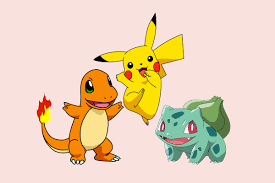

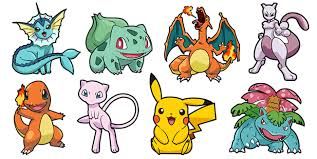</div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")
pd.options.plotting.backend = "plotly"

data = pd.read_csv('../input/pokemon/Pokemon.csv')
data.drop('#', axis=1, inplace=True)

# Description of Data

In [ ]:
sns.heatmap(data.corr())
plt.title('Correlation')
plt.show()

# Treating missing values

In [ ]:
fig = data.isnull().sum().reset_index().plot(kind='bar', x='index', y=0)
fig.update_layout(title='Missing values plot', xaxis_title='Columns', yaxis_title='Missing Count')
fig.show()

The variables type 1 and type 2 denotes power for each of the pokemons. Since I am taking type 1 into consideration type 2 won't be of that much significance.

Also out of 800 values 386 is missing and hence it will be better to drop that variable before clustering or classification on the data.

# Distribution of data

In [ ]:
fig = data['Type 1'].value_counts().reset_index().plot(kind='bar', y='index', x='Type 1', color='Type 1')
fig.update_layout(title='Abilities of Pokemons', yaxis_title='Ability', xaxis_title='Count')
fig.show()

In [ ]:
sns.FacetGrid(data, hue="Legendary", height=6,).map(sns.kdeplot, "Total",shade=True).add_legend()
plt.title('KDE Plot for Total Strength')
plt.show()

A bimodal distribution can be noticed for total strength values in case of both legendary and non legendary. 

Looking at the data it can be confirmed that total is a summation of HP, Attack, Defense Sp., Atk Sp., Def,	and Speed variables.

So I am not separately plotting the distributions of these variables rather I will be using a pairplot to denote them all.

In [ ]:
sns.pairplot(data=data[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation']], hue='Generation')
print('Pairplot segregated on generation')
plt.show()

In [ ]:
sns.pairplot(data=data[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Legendary']], hue='Legendary')
print('Pairplot segregated on Legendariness')
plt.show()

# Treating Outliers

In [ ]:
sns.boxplot(data=data, x='Generation', y='Total')
plt.title('Total /b Generation')
plt.show()

From the above boxplot few outliers can be noticed. 

So it can be inferred that any generation 1 pokemon with total strength above 700 is an outlier to the data. 

Let's take a look at the data remove it.

In [ ]:
data[(data['Generation']==1) & (data['Total']>700)]

On taking a look at the data though I can see that the outliers refer to Mewtwo, a legendary pokemon and it is totally justified for this pokemon to have the highest strength. 

So I won't be dropping these indices.

Rather than generation it seems that creating boxplots based on legenadary variable values will be more beneficial

In [ ]:
sns.boxplot(data=data, x='Legendary', y='HP')
plt.title('HP /b Legendary')
plt.show()

The above plot tells that any HP value greater than 130 is an outlier but considering the background of the data there are two things that mainly interest me.
1. HP values above 160
2. HP value closest to 0

Let's check more on this data

In [ ]:
data[(data['HP']>160) | (data['HP']==data['HP'].min())]

Out of the above data points visited the ones that aroused my interest are Chansey, Blissey and Shedninja. 

Neither they are legendary nor they have any special ability that justifies their difference from other pokemons. 

So it's better to drop these three.

In [ ]:
#dropping 121, 261 and 316 indices in the dataset

data = data.drop([121, 261, 316]).reset_index(drop=True)

In [ ]:
fig = plt.figure(figsize=(15,30))
fig.add_subplot(5,2,1)
sns.boxplot(data=data, x='Generation', y='Attack', hue='Legendary')
plt.title('Attack /b Generation')

fig.add_subplot(5,2,2)
sns.boxplot(data=data, x='Generation', y='Defense')
plt.title('Defense /b Generation')

fig.add_subplot(5,2,3)
sns.violinplot(data=data, x='Legendary', y='Speed')
plt.title('Speed /b Legendary')
plt.show()

In the above plots on attack, defense and speed many outliers can be noticed but looking at the data those are justified there and are not caused due to any mistake in data collection or gathering.

# Encoding categorical variable

In [ ]:
data['Type 1'] = data['Type 1'].astype('category')

Since the encoding is for clustering model, label encoding will be better in this case

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['Type 1'] = le.fit_transform(data['Type 1'])

# Clustering the data

In [ ]:
df = data.drop(['Name','Type 2','Generation','Legendary'], axis=1)

from sklearn.cluster import KMeans

X = np.array(df)

kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X)

df['cluster_label'] = pd.Series(list(kmeans.labels_))

In [ ]:
fig = df['cluster_label'].value_counts().reset_index().plot(kind='bar',x='index',y='cluster_label', color='cluster_label')
fig.update_layout(title='Distribution of the cluster labels', xaxis_title='Cluster', yaxis_title='Count')
fig.show()

In [ ]:
fig = data['Generation'].value_counts().reset_index().plot(kind='bar',x='index',y='Generation', color='Generation')
fig.update_layout(title='Distribution of the Generation', xaxis_title='Generation', yaxis_title='Count')
fig.show()

In [ ]:
fig = plt.figure(figsize=(15,30))
fig.add_subplot(5,2,1)
sns.kdeplot(data=df['cluster_label'])
plt.title('Cluster Label')


fig.add_subplot(5,2,2)
sns.kdeplot(data=data['Generation'])
plt.title('Generations')

plt.show()

It seems that the clustering wasn't accurate enough to capture the right counts of each of the category in the Generation variable.

But from the distribution a similarity can still be noticed between the two.

# Classifying pokemons

In [ ]:
data = pd.read_csv('../input/pokemon/Pokemon.csv')
data.drop(['#','Type 2'], axis=1, inplace=True)
data = data.drop([121, 261, 316]).reset_index(drop=True)

The data is missing value free.

All the features present now are required ones so there is no need to drop any further variables.

No new feature seems to get created from the existing ones.

Let's get down to encode the categorical variables.

In [ ]:
data.head()

The Type 1 variable will be one hot encoded since its a nominal variable and have <20 categories.

While the generation variable is an ordinal one and is already in the label-encoded format.

In [ ]:
#one hot encoding

dummy = pd.get_dummies(data['Type 1'])
dummy.drop('Grass', axis=1, inplace=True) #dropping to avoid dummy variable trap
data = pd.concat([data, dummy], axis=1)
del data['Type 1'] #dropping the variable after encoded

Let's shuffle the dataset once since it seems the target variable is separated perfectly.

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

Let's now check the target variable. 

It's labels and the distribution

In [ ]:
sns.barplot(data=data['Legendary'].value_counts().reset_index(), x='index', y='Legendary')
plt.xlabel('Legendary')
plt.ylabel('')
plt.title('Distribution of target variable')
plt.show()

Let's drop the Name variable as well and then we can advance to splitting the data and building the model.

In [ ]:
data.drop('Name', axis=1, inplace=True)

In [ ]:
#splitting the data

from sklearn.model_selection import train_test_split

X = data.drop('Legendary', axis=1)
y = data['Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve,accuracy_score,plot_confusion_matrix

In [ ]:
model = DecisionTreeClassifier(max_depth=5, random_state=13)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print('The accuracy of the Decision Tree is', accuracy_score(prediction, y_test))

In [ ]:
plot_confusion_matrix(model, X_test, y_test)
plt.title('Decision Tree Confusion Matrix')
plt.show()

model = DecisionTreeClassifier(max_depth=5, random_state=13)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

The Decision Tree classifier is providing the best accuracy and I have checked if hypertuning further is increasing the score or not.

I used a decision tree since it is insensitive to outliers and there are many outliers in the data if considered from the statistical point of view.

## Final Accuracy: 95.14%

## Do drop an upvote if you like the kernel.